# TP 05 SVM 
### Date: 2017.10.18
### Author: Christophe Gisler
##### Update to Python 3: Lorenz Rychener, Christophe Gisler

#### Imports

In [2]:
import _pickle as cPickle
import gzip
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

# get_ipython().magic(u'matplotlib inline')

# Exercice 1

#### B) Load MNIST digit datasets (see http://deeplearning.net/tutorial/gettingstarted.html)

In [3]:
# Load training, validation and test datasets
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f, encoding='latin1')
f.close()

# Print the sizes of the various datasets
print("Training set: %d samples\nValidation set: %d samples (not used in the TP)\nTest set: %d samples" % (len(train_set[0]), len(valid_set[0]), len(test_set[0])))

Training set: 50000 samples
Validation set: 10000 samples (not used in the TP)
Test set: 10000 samples


#### C) Visualize the images of some digits of the MNIST database

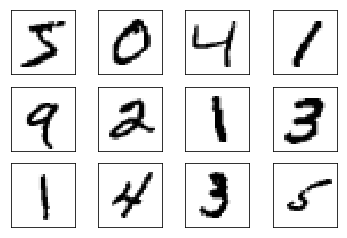

In [4]:
# Plot a MNIST image (each image is represented as a 2-d numpy array).
def plot_images(data_set, start_index, end_index, images_per_row):
    images = [np.reshape(f, (-1, 28)) for f in data_set[0][start_index:end_index] ]
    fig = plt.figure()
    n = end_index - start_index
    for i in range(n):
        ax = fig.add_subplot(n/images_per_row, images_per_row, i + 1)
        ax.matshow(images[start_index + i], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

plot_images(train_set, 0, 12, 4)

#### C) Build final balanced training and test sets

In [5]:
def select_samples(data_set, samples_per_class):
    Xs = []
    ys = []
    tot = 0
    ctrPerClass = {}
    for i in range(len(data_set[0])):
        X = data_set[0][i]
        y = data_set[1][i]
        ctrPerClass.setdefault(y, 0)
        if ctrPerClass[y] < samples_per_class:
            Xs.append(X)
            ys.append(y)
            ctrPerClass[y] = ctrPerClass[y] + 1
            tot += 1
        if tot >= 10 * samples_per_class:
            break
    return Xs, ys

# Build final training set that will be composed of N samples for each class (i.e. digit)
#X_train = train_set[0]
#y_train = train_set[1]
train_samples_per_class = 200
X_train, y_train = select_samples(train_set, train_samples_per_class)
print("Final training set: %d samples (%d samples per class, 10 classes)" % (len(X_train), train_samples_per_class))

# Build final test set (just take test_set as it is)
#X_test  = test_set[0]
#y_test  = test_set[1]
test_samples_per_class = 100
X_test, y_test = select_samples(test_set, test_samples_per_class)
print("Final test set: %d samples (%d samples per class, 10 classes)" % (len(X_test), test_samples_per_class))
    
# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)



Final training set: 2000 samples (200 samples per class, 10 classes)
Final test set: 1000 samples (100 samples per class, 10 classes)


# Exercice 2 : Classification of digits based on raw pixel values using SVM and different kernels

#### Use SVM classifier with different kernels and parameters to recognize digits

In [6]:
# Set the number of folds for Cross-Validation and SVM tuning
cv_folds = 10

# Create different SVM classifier(s)
classifiers = {"svm-Linear" : GridSearchCV(SVC(kernel='linear', cache_size=7000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [1, 10, 100, 1000]}),
               "svm-Polynomial" : GridSearchCV(SVC(kernel='poly', degree=2, cache_size=7000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [1, 10, 100, 1000],
                                   "gamma": [1e-2,1e-3, 1e-4, 1e-5]}),
                "svm-RBF" : GridSearchCV(SVC(kernel='rbf', gamma=0.1, cache_size=7000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [1, 10, 100, 1000],
                                   "gamma": [1e-2,1e-3, 1e-4, 1e-5]})
               }



In [7]:
for name, classifier in classifiers.items():
    t0 = time.time()
    print("%s:" % name) 
    
    # Train SVM classifier on the training set
    classifier.fit(X_train, y_train) 
    print("- Best classifier found using %d-fold CV (grid search) in %0.3fs:\n  %s" % (cv_folds, time.time() - t0, classifier.best_estimator_))
    
    # Predict number labels using the trained classifier on the test set
    y_pred = classifier.predict(X_test)

    # Print classification results with confusion matrix
    print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))
    print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))
    
    # Print computation time
    print("- Computation time: %0.3fs\n" % (time.time() - t0))

svm-Linear:
- Best classifier found using 10-fold CV (grid search) in 29.934s:
  SVC(C=1, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Classification report for classifier GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       100
           1       0.93      0.99  

# Exercice 3 : ) Impact of preprocessing and feature extraction

#### A) Preprocessing steps : binarization

In [8]:
def binarization(X):
    return np.array(X > 0, dtype=int)

In [9]:
# Set the number of folds for Cross-Validation and SVM tuning
cv_folds = 10

# Create different SVM classifier(s)
classifiers = {"svm-Linear" : GridSearchCV(SVC(kernel='linear', cache_size=7000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [1, 10, 100, 1000]}),
               "svm-Polynomial" : GridSearchCV(SVC(kernel='poly', degree=2, cache_size=7000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [1, 10, 100, 1000],
                                   "gamma": [1e-2,1e-3, 1e-4, 1e-5]}),
                "svm-RBF" : GridSearchCV(SVC(kernel='rbf', gamma=0.1, cache_size=7000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [1, 10, 100, 1000],
                                   "gamma": [1e-2,1e-3, 1e-4, 1e-5]})
               }

for name, classifier in classifiers.items():
    t0 = time.time()
    print ("%s:" % name) 
    
    # Train SVM classifier on the training set
    classifier.fit(binarization(X_train), y_train) 
    print ("- Best classifier found using %d-fold CV (grid search) in %0.3fs:\n  %s" % (cv_folds, time.time() - t0, classifier.best_estimator_))
    
    # Predict number labels using the trained classifier on the test set
    y_pred = classifier.predict(binarization(X_test))

    # Print classification results with confusion matrix
    print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))
    print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))
    
    # Print computation time
    print("- Computation time: %0.3fs\n" % (time.time() - t0))

svm-Linear:
- Best classifier found using 10-fold CV (grid search) in 34.102s:
  SVC(C=1, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Classification report for classifier GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.93      1.00  

#### B) Feature extraction steps : Vertical projections

In [10]:
def vertical_projection(X):
    images = np.array([np.reshape(f, (-1, 28)).sum(0) for f in X])
    return images

In [11]:
# Set the number of folds for Cross-Validation and SVM tuning
cv_folds = 10
# Create different SVM classifier(s)
classifiers = {"svm-Linear" : GridSearchCV(SVC(kernel='linear', cache_size=7000, max_iter=1000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [0.001, 0.01, 0.1, 1]}),
                "svm-RBF" : GridSearchCV(SVC(kernel='rbf', gamma=0.1, cache_size=7000, max_iter=1000), cv=cv_folds, n_jobs=-1,
                       param_grid={"C": [0.001, 0.01, 0.1, 1],
                                   "gamma": [1e-2,1e-3, 1e-4, 1e-5]})
               }



In [12]:
for name, classifier in classifiers.items():
    t0 = time.time()
    print("%s:" % name) 
    
    # Train SVM classifier on the training set
    classifier.fit(vertical_projection(X_train), y_train) 
    print("- Best classifier found using %d-fold CV (grid search) in %0.3fs:\n  %s" % (cv_folds, time.time() - t0, classifier.best_estimator_))
    
    # Predict number labels using the trained classifier on the test set
    y_pred = classifier.predict(vertical_projection(X_test))

    # Print classification results with confusion matrix
    print("Classification report for classifier %s:\n%s\n" % (classifier, metrics.classification_report(y_test, y_pred)))
    print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))
    
    # Print computation time
    print("- Computation time: %0.3fs\n" % (time.time() - t0))

svm-Linear:


/Users/gislerc/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


- Best classifier found using 10-fold CV (grid search) in 2.307s:
  SVC(C=0.001, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=1000, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Classification report for classifier GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=1000, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       0.43      0.56      0.48       100
           1       0.55      0.94    